In [492]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import pickle
import diagnostic_plots
import datetime
import random

from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn import feature_selection as f_select
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from copy import deepcopy
from fancyimpute import MICE as MICE
from sklearn.cross_validation import KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from statsmodels.stats.outliers_influence import variance_inflation_factor    

%matplotlib inline
%config InlineBackend.figure_format = 'svg';

In [455]:
with open('./data/processed/reduced_df2.pkl', 'rb') as picklefile:
    reduced_df2 = pickle.load(picklefile)
y = reduced_df2['price']
X = reduced_df2.drop(('price'), axis = 1, inplace = False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=666)
y_train_log = np.log(y_train)

## Impute the missing data

In [450]:
def calc_training_avg(df, col, navalues):    
    non_na = df    
    df[col] = df[col].astype(str)   
    for navalue in navalues:
        non_na = non_na.loc[non_na[col]!= navalue]   
    cal_mean = np.mean(non_na[col].astype(float))    
    for navalue in navalues:
        df.loc[df[col] == navalue, col] = cal_mean
    return df[col].astype(float), cal_mean

In [451]:
col_to_clean = ['city', 'highway', 'engine', 'cylinder', 'horsepower', 'torque']

training_mean_dict = {}
for col in col_to_clean:
    X_train.loc[:,col], cal_mean = calc_training_avg(X_train, col, ['N/A', '0'])
    training_mean_dict[col] = cal_mean

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [456]:
def standardize_na(df, cols, navalues):
    for col in cols:
        for navalue in navalues:
            df.loc[df[col] == navalue, col] = np.nan
        df[col] = df[col].astype(float)
        #df.loc[df[col] == '123456789.0', col] = np.nan
    return df

In [457]:
col_to_clean = ['city', 'highway', 'engine', 'cylinder', 'horsepower', 'torque']
na_values = ['N/A', '0']

X_train = standardize_na(X_train, col_to_clean, na_values)
#X_train_imputed = pd.DataFrame(data = MICE().complete(X_train.as_matrix()), columns=X_train.columns, index=X_train.index);
imputer = preprocessing.Imputer(missing_values='NaN', strategy ='most_frequent', axis=0)
imputer_fit = imputer.fit(X_train)
X_train_imputed = imputer_fit.transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns, index=X_train.index)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [458]:
X_train_imputed[col_to_clean].describe()

,city,highway,engine,cylinder,horsepower,torque
count,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000
mean,23.560099,31.780669,2.737831,4.910781,227.804833,230.353160
std,10.392951,8.567820,1.099036,1.300282,77.866417,90.124948
min,12.000000,16.000000,0.060000,2.000000,70.000000,68.000000
25%,19.000000,27.000000,2.000000,4.000000,172.000000,172.000000
50%,22.000000,32.000000,2.400000,4.000000,208.000000,235.000000
75%,25.000000,36.000000,3.500000,6.000000,285.000000,264.000000
max,128.000000,109.000000,6.700000,8.000000,550.000000,925.000000


## Basic EDA

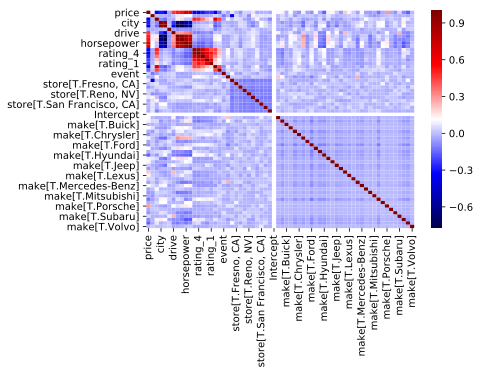

In [342]:
df_train = pd.concat((y_train, X_train), axis=1)
sns.heatmap(df_train.corr(), cmap="seismic");

for col in df_num_train:
    plt.figure()
    ax = plt.scatter(x=df_num_train[col], y=y_train)
    plt.xlabel(col)
    plt.ylabel('price')

## Model 1: Baseline model with all variables

In [560]:
def get_CV_score(df_x, df_y, intercept_present):
    kf = KFold(n=len(df_x), n_folds=5, shuffle=True, random_state=123)
    model_scores =[]
    for train, test in kf:
        X_train_cv = df_x.iloc[train]
        y_train_cv = df_y.iloc[train]
        X_test_cv = df_x.iloc[test]
        y_test_cv = df_y.iloc[test]
        #model = LinearRegression(fit_intercept=intercept_present)
        #model.fit(X_train_cv, y_train_cv)
        if (intercept_present):
            model = sm.OLS(y_train_cv, X_train_cv).fit()
            score = mean_squared_error(model.predict(X_test_cv), y_test_cv)
        else:
            model = sm.OLS(y_train_cv, sm.add_constant(X_train_cv)).fit()
            score = mean_squared_error(model.predict(sm.add_constant(X_test_cv)), y_test_cv)
        model_scores.append(score)
    return np.sqrt(np.mean(model_scores))

In [592]:
get_CV_score(X_train_pca, y_train_log, False)

0.21612895394340081

In [545]:
model = LinearRegression(fit_intercept=)
model.fit(X_train_cv, y_train_cv)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [546]:
model.intercept_

0.0

In [495]:
index = random.sample(range(X_train_pca.shape[0]), int(np.round(X_train_pca.shape[0]*0.8)))

In [503]:
msk = np.random.rand(len(X_train_pca)) < 0.8

In [506]:
train_tmp = X_train_pca[msk]
test_tmp = X_train_pca[~msk]
y_train_tmp = y_train_log[msk]
y_test_tmp = y_train_log[~msk] 

In [512]:
test_tmp.head()

,pca1,pca2,pca3,pca4
stock_id,,,,
16057160,-72.666224,-14.566691,9.662357,0.110350
16211748,261.841064,-16.772072,-43.775792,7.137592
15832704,-67.088349,-15.365837,-7.695876,5.749415
15425515,80.676372,24.275779,-22.089709,-7.466554
16062799,86.911420,-12.049500,-32.195180,2.880020


In [513]:
y_test_tmp.head()

stock_id
16057160     9.392495
16211748    11.002067
15832704     9.952182
15425515    10.085726
16062799     9.852089
Name: price, dtype: float64

In [556]:
model = sm.OLS(y_train_tmp, train_tmp).fit()
print (model.predict(test_tmp)[0:10])
print (y_test_tmp[0:10])

stock_id
16057160    0.091265
16211748    0.355503
15832704    0.106107
15425515   -0.200106
16062799    0.173608
15711481   -0.318004
16062161    0.031600
15879648   -0.144088
16058406    0.003783
16063735    0.225396
dtype: float64
stock_id
16057160     9.392495
16211748    11.002067
15832704     9.952182
15425515    10.085726
16062799     9.852089
15711481     9.740851
16062161     9.998707
15879648     9.654962
16058406     9.546670
16063735    10.025661
Name: price, dtype: float64


In [517]:
print (model.predict(train_tmp)[0:10])
print (y_train_tmp[0:10])

stock_id
16057266   -0.017754
15867037    0.349581
16062084    0.100892
16062460    0.188818
16062763   -0.082384
16182316    0.085377
16211408    0.273595
15823992   -0.067788
16062200   -0.145221
15438636   -0.048631
dtype: float64
stock_id
16057266     9.615672
15867037    10.025661
16062084     9.441373
16062460     9.903388
16062763     9.775597
16182316     9.472551
16211408     9.392495
15823992     9.615672
16062200     9.798016
15438636     9.441373
Name: price, dtype: float64


In [461]:
model1_score = get_CV_score(X_train_imputed, y_train_log)
print ('Model 1 CV RMSE is:', model1_score)

Model 1 CV RMSE is: 0.143897364578


In [462]:
model1_sm = sm.OLS(y_train_log, X_train_imputed).fit()
score = mean_squared_error(model1_sm.predict(X_train_norm), y_train_log)
score = np.sqrt(np.mean(score))
print ('Model 1 training RMSE is:', score)
model1_sm.summary()

Model 1 training RMSE is: 9.88375106158


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     175.6
Date:                Thu, 19 Jul 2018   Prob (F-statistic):               0.00
Time:                        10:27:46   Log-Likelihood:                 919.99
No. Observations:                1614   AIC:                            -1714.
Df Residuals:                    1551   BIC:                            -1375.
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
images                         0.0021      0.001      3.057      0.002       0.001       0.003
age                           -0.0527      0.003    -19.483      0.000      -0.058      -0.047
city                           0.0111      0.001     11.278      0.000       0.009       0.013
highway                       -0.0173      0.001    -13.184      0.000      -0.020      -0.015
transmission                  -0.0141      0.017     -0.827      0.408      -0.047       0.019
drive                          0.1315      0.011     11.811      0.000       0.110       0.153
engine                         0.0265      0.012      2.288      0.022       0.004       0.049
cylinder                       0.0098      0.009      1.100      0.271      -0.008       0.027
horsepower                     0.0011      0.000      7.932      0.000       0.001       0.001
torque                         0.0010   9.81e-05     10.366      0.000       0.001       0.001
rating_5                       0.0003      0.000      0.513      0.608      -0.001       0.001
rating_4                    8.064e-06      0.001      0.006      0.995      -0.003       0.003
rating_3                       0.0014      0.003      0.444      0.657      -0.005       0.008
rating_2                      -0.0101      0.005     -2.002      0.045      -0.020      -0.000
rating_1                       0.0056      0.005      1.096      0.273      -0.004       0.016
mileage                       -0.0037      0.000    -18.154      0.000      -0.004      -0.003
owner                       3.677e-05      0.006      0.006      0.995      -0.011       0.011
event                          0.0311      0.024      1.283      0.200      -0.016       0.079
recall                         0.0037      0.009      0.400      0.689      -0.015       0.022
store[T.Fremont, CA]           0.0650      0.018      3.569      0.000       0.029       0.101
store[T.Fresno, CA]            0.0337      0.020      1.716      0.086      -0.005       0.072
store[T.Modesto, CA]           0.0361      0.018      2.020      0.044       0.001       0.071
store[T.Pleasanton, CA]        0.0233      0.017      1.354      0.176      -0.010       0.057
store[T.Reno, NV]              0.0104      0.018      0.582      0.561      -0.025       0.046
store[T.Roseville, CA]         0.0317      0.017      1.868      0.062      -0.002       0.065
store[T.Sacramento, CA]        0.0311      0.018      1.697      0.090      -0.005       0.067
store[T.San Francisco, CA]    -0.0015      0.017     -0.087      0.931      -0.036       0.033
store[T.San Jose, CA]          0.0073      0.018      0.405      0.685      -0.028       0.043
store[T.Santa Rosa, CA]       -0.0030      0.017     -0.174      0.862      -0.037       0.031
Intercept                      9.9411      

<span style="color:red"> ** The condition number is large, 1.72e+04. This might indicate that there are strong multicollinearity or other numerical problems. **</span>

## Check and rectify multi-collinearity

In [463]:
def remove_high_vif(df, threshold):
    dfx = deepcopy(df)
    col_dropped = []
    check_further = True
    while check_further:
        vif_values = [variance_inflation_factor(dfx.values, i) for i in range(dfx.shape[1])]        
        vif_table = pd.DataFrame(list(zip(dfx.columns.tolist(), vif_values)), columns=['colname', 'vif'])
        if (vif_table.vif.max()<threshold):
                      check_further = False
                      break
        else:
                      drop_col = vif_table.iloc[vif_table.vif.idxmax(),0]
                      col_dropped.append(drop_col)
                      dfx.drop([drop_col], axis=1, inplace=True)
    print ("remaining variables are: \n", vif_table)
    return dfx, col_dropped

In [464]:
X_train_vif, removed_cols_high_vif = remove_high_vif(X_train_imputed, 5)

remaining variables are: 
                        colname       vif
0                 transmission  1.125096
1                        drive  1.670675
2                     rating_5  4.177393
3                     rating_3  3.029138
4                     rating_2  2.432800
5                     rating_1  2.092454
6                      mileage  4.709829
7                        event  1.078313
8                       recall  1.363672
9         store[T.Fremont, CA]  2.331274
10         store[T.Fresno, CA]  1.639051
11        store[T.Modesto, CA]  2.058714
12     store[T.Pleasanton, CA]  2.279833
13           store[T.Reno, NV]  2.115801
14      store[T.Roseville, CA]  2.379311
15     store[T.Sacramento, CA]  2.047647
16  store[T.San Francisco, CA]  2.246935
17       store[T.San Jose, CA]  2.067183
18     store[T.Santa Rosa, CA]  2.194036
19                make[T.Audi]  1.368197
20                 make[T.BMW]  2.006208
21               make[T.Buick]  1.151406
22            make[T.Cadillac]

In [465]:
print ("variables with high vif are removed:", removed_cols_high_vif)

variables with high vif are removed: ['Intercept', 'cylinder', 'highway', 'horsepower', 'engine', 'rating_4', 'age', 'images', 'torque', 'city', 'owner']


## Model 2: Fit all remaining columns

In [578]:
model2_score = get_CV_score(X_train_vif, y_train_log, False)
print ('Model 2 CV RMSE is:', model2_score)

Model 2 CV RMSE is: 0.245816991298


In [580]:
model2_sm = sm.OLS(y_train_log, sm.add_constant(X_train_vif)).fit()
score = mean_squared_error(model2_sm.predict(sm.add_constant(X_train_vif)), y_train_log)
score = np.sqrt(np.mean(score))
print ('Model 2 training RMSE is:', score)
model2_sm.summary()

Model 2 training RMSE is: 0.235842415824


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     51.04
Date:                Thu, 19 Jul 2018   Prob (F-statistic):          3.59e-295
Time:                        13:32:48   Log-Likelihood:                 41.404
No. Observations:                1614   AIC:                             23.19
Df Residuals:                    1561   BIC:                             308.7
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         10.1246      0.054    186.334      0.000      10.018      10.231
transmission                  -0.0705      0.029     -2.448      0.014      -0.127      -0.014
drive                          0.3395      0.017     19.513      0.000       0.305       0.374
rating_5                      -0.0007      0.001     -1.366      0.172      -0.002       0.000
rating_3                      -0.0121      0.005     -2.496      0.013      -0.022      -0.003
rating_2                      -0.0129      0.009     -1.513      0.130      -0.030       0.004
rating_1                      -0.0151      0.009     -1.764      0.078      -0.032       0.002
mileage                       -0.0054      0.000    -20.332      0.000      -0.006      -0.005
event                          0.0183      0.042      0.441      0.659      -0.063       0.100
recall                        -0.0188      0.016     -1.180      0.238      -0.050       0.012
store[T.Fremont, CA]           0.0487      0.030      1.638      0.102      -0.010       0.107
store[T.Fresno, CA]            0.0163      0.034      0.483      0.629      -0.050       0.082
store[T.Modesto, CA]          -0.0282      0.031     -0.924      0.356      -0.088       0.032
store[T.Pleasanton, CA]        0.0145      0.029      0.492      0.623      -0.043       0.072
store[T.Reno, NV]             -0.0104      0.031     -0.341      0.733      -0.070       0.049
store[T.Roseville, CA]         0.0308      0.029      1.058      0.290      -0.026       0.088
store[T.Sacramento, CA]       -0.0068      0.031     -0.216      0.829      -0.068       0.055
store[T.San Francisco, CA]    -0.0705      0.030     -2.358      0.019      -0.129      -0.012
store[T.San Jose, CA]         -0.0554      0.031     -1.795      0.073      -0.116       0.005
store[T.Santa Rosa, CA]       -0.0364      0.030     -1.219      0.223      -0.095       0.022
make[T.Audi]                   0.0440      0.067      0.660      0.509      -0.087       0.175
make[T.BMW]                    0.1228      0.053      2.309      0.021       0.018       0.227
make[T.Buick]                 -0.1836      0.070     -2.615      0.009      -0.321      -0.046
make[T.Cadillac]               0.2556      0.085      3.018      0.003       0.089       0.422
make[T.Chevrolet]             -0.0781      0.054     -1.459      0.145      -0.183       0.027
make[T.Chrysler]              -0.1908      0.068     -2.810      0.005      -0.324      -0.058
make[T.Dodge]                  0.0393      0.055      0.716      0.474      -0.068       0.147
make[T.Fiat]                  -0.3475      0.077     -4.509      0.000      -0.499      -0.196
make[T.Ford]                  -0.1251      0.051     -2.455      0.014      -0.225      -0.025
make[T.GMC]                    0.1955      

** Now cond number is 2.15e+3, still very large, especially considering the outcome is in log scale **

## Check ridge regularization

In [359]:
X_train_ridge = deepcopy(X_train_imputed)
kf = KFold(n=len(X_train_ridge), n_folds=5, shuffle=True)
alphas = [10**x for x in range(-12, 5)]
scores = np.zeros((len(alphas),1))

In [360]:
for j in range(len(alphas)):
    kf_score = []
    for train, test in kf:
        X_train_cv = X_train_ridge.iloc[train]
        y_train_cv = y_train.iloc[train]
        X_test_cv = X_train_ridge.iloc[test]
        y_test_cv = y_train.iloc[test]
        std_scaler = preprocessing.StandardScaler()
        X_train_norm = std_scaler.fit_transform(X_train_cv)
        X_test_norm = std_scaler.transform(X_test_cv)
    
        model =  Ridge(alpha = alphas[j])
        model.fit(X_train_norm, y_train_cv)
        y_test_predict = model.predict(X_test_norm)
        score = mean_squared_error(y_test_predict, y_test_cv)
        kf_score.append(score)
    scores[j] = np.sqrt(np.mean(kf_score))
print ('RMSE for all alpha values \n')
print (pd.DataFrame(list(zip(alphas, scores)), columns=['alpha', 'rmse']))

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.730469546826012e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.746092770187248e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.552464403093379e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/scipy/linalg/ba

RMSE for all alpha values 

           alpha             rmse
0   1.000000e-12  [3769.97799631]
1   1.000000e-11  [3769.97799631]
2   1.000000e-10  [3769.97799631]
3   1.000000e-09  [3769.97799631]
4   1.000000e-08   [3769.9779963]
5   1.000000e-07  [3769.97799624]
6   1.000000e-06  [3769.97799563]
7   1.000000e-05  [3769.97798947]
8   1.000000e-04  [3769.97792789]
9   1.000000e-03  [3769.97731218]
10  1.000000e-02  [3769.97116149]
11  1.000000e-01  [3769.91029634]
12  1.000000e+00  [3769.36257133]
13  1.000000e+01   [3767.9111092]
14  1.000000e+02  [3817.67754001]
15  1.000000e+03  [4399.92065716]
16  1.000000e+04  [6828.98317847]


In [363]:
best_alpha = alphas[scores.argmin()]
print ('best alpha is:', best_alpha, "\nCV RMSE:", (scores.min()))

best alpha is: 10 
CV RMSE: 3767.9111092


In [366]:
y_train.shape

(1614,)

A workaround to show summary table for ridge regression <br>
https://stackoverflow.com/questions/40072870/statistical-summary-table-in-sklearn-linear-model-ridge

In [393]:
std_scaler = preprocessing.StandardScaler()
X_train_norm = std_scaler.fit_transform(X_train_ridge)

model4_sm = sm.OLS(y_train, X_train_norm)
results_fu = model4_sm.fit()
#y_train_predict = model4_sm.predict(X_train_norm)
#model4_score = mean_squared_error(y_train_predict, y_train)
#print ('RMSE of model 4 is:', np.sqrt(model4_score))

In [399]:
frames = []
for n in np.arange(0, 0.25, 0.05).tolist():
    results_fr = model4_sm.fit_regularized(L1_wt=0, alpha=n, start_params=results_fu.params)

    results_fr_fit = sm.regression.linear_model.OLSResults(model4_sm, 
                                                           results_fr.params, 
                                                           model4_sm.normalized_cov_params)
    frames.append(np.append(results_fr.params, results_fr_fit.ssr))

    df = pd.DataFrame(frames, columns=X_train_ridge.columns.tolist() + ['ssr*'])
df.index=np.arange(0, 0.25, 0.05).tolist()
df.index.name = 'alpha*'
df.T

alpha*,0.0,0.05,0.1,0.15000000000000002,0.2
images,2.978582e+02,2.991597e+02,2.935524e+02,2.868752e+02,2.799473e+02
age,-2.469880e+03,-2.113173e+03,-1.936988e+03,-1.807586e+03,-1.704345e+03
city,2.530973e+03,1.276982e+03,8.107222e+02,5.681326e+02,4.174742e+02
highway,-3.072182e+03,-1.716454e+03,-1.225985e+03,-9.842409e+02,-8.427269e+02
transmission,8.929156e+01,6.021613e+01,3.570339e+01,1.853457e+01,5.496245e+00
drive,1.149953e+03,1.333423e+03,1.360427e+03,1.356707e+03,1.341467e+03
engine,5.560612e+02,6.601499e+02,6.952807e+02,7.121306e+02,7.214506e+02
cylinder,7.805734e+02,7.433191e+02,7.543980e+02,7.634755e+02,7.697444e+02
horsepower,8.780372e+02,1.278089e+03,1.394508e+03,1.436920e+03,1.449281e+03
torque,3.153264e+03,2.632027e+03,2.390221e+03,2.229864e+03,2.110199e+03


In [402]:
results_fr = model4_sm.fit_regularized(L1_wt=0, alpha=10, start_params=results_fu.params)
model4_ridge = sm.regression.linear_model.OLSResults(model4_sm, 
                                              results_fr.params, 
                                              model4_sm.normalized_cov_params)

print (model4_ridge.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1.537
Date:                Thu, 19 Jul 2018   Prob (F-statistic):            0.00517
Time:                        08:55:47   Log-Likelihood:                -18385.
No. Observations:                1614   AIC:                         3.689e+04
Df Residuals:                    1552   BIC:                         3.723e+04
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            59.3915    621.955      0.095      0.9

In [396]:
np.sqrt(mean_squared_error(results_fr.predict(X_train_ridge), y_train))

166456.18918586985

In [411]:
X.head()

,images,age,city,highway,transmission,drive,engine,cylinder,horsepower,torque,...,make[T.Mitsubishi],make[T.Nissan],make[T.Pontiac],make[T.Porsche],make[T.Scion],make[T.Smart],make[T.Subaru],make[T.Toyota],make[T.Volkswagen],make[T.Volvo]
stock_id,,,,,,,,,,,,,,,,,,,,,
16061803,23,6,20,29,0,0,3.5,6,280,254,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15824438,22,2,24,35,0,0,2.4,4,206,182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15165784,21,4,23,33,0,0,1.8,4,170,200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15210066,21,4,N/A,N/A,0,0,2.0,4,N/A,N/A,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15824549,22,3,24,33,0,1,2.0,4,220,258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(array([  13.,  150.,  484.,  516.,  407.,  338.,  156.,   65.,   18.,    6.]),
 array([  8.85337967,   9.09948672,   9.34559377,   9.59170081,
          9.83780786,  10.0839149 ,  10.33002195,  10.576129  ,
         10.82223604,  11.06834309,  11.31445014]),
 <a list of 10 Patch objects>)

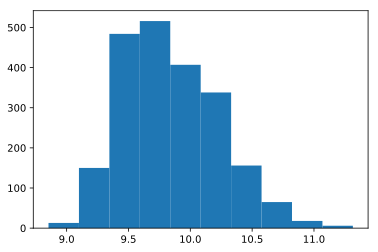

In [413]:
plt.hist(np.log(y))

## Check how we can fit better

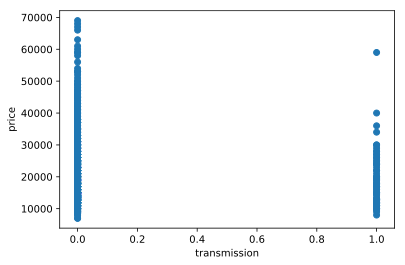

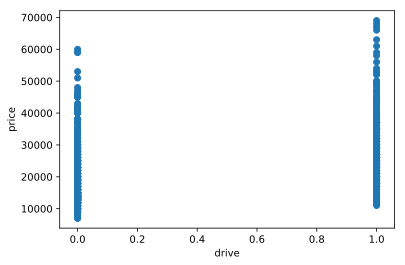

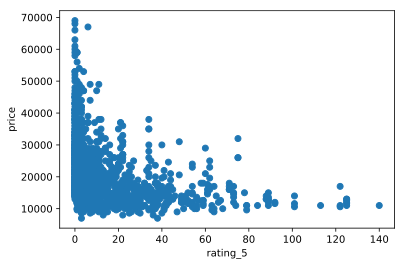

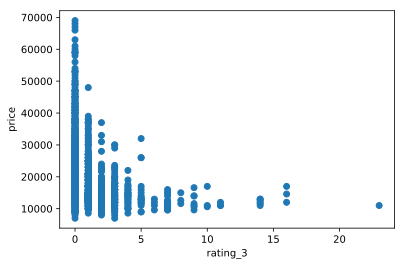

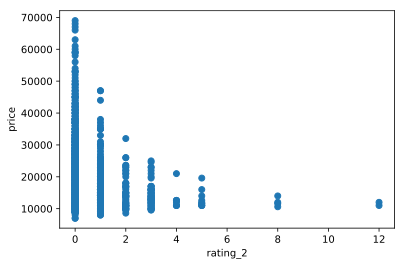

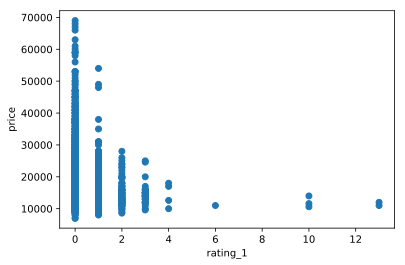

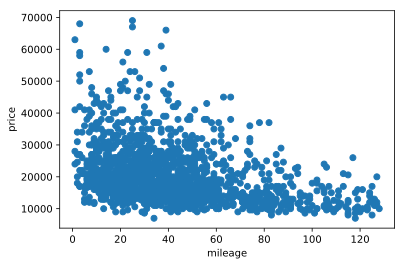

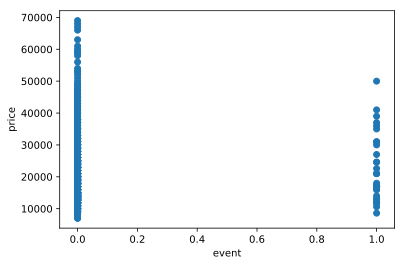

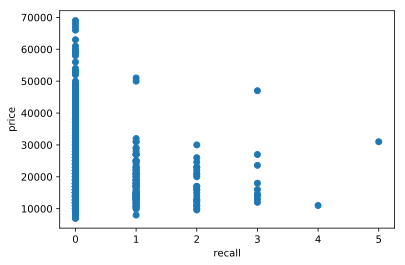

In [288]:
for col in X_train_vif.columns.tolist()[0:9]:
    plt.figure()
    ax = plt.scatter(x=X_train_vif[col], y=y_train)
    plt.xlabel(col)
    plt.ylabel('price')

In [166]:
df_pvalue = pd.DataFrame(list(zip(model2_sm.params.index, model2_sm.pvalues)), columns=['variable', 'pvalue'])
significant_var = (df_pvalue[df_pvalue['pvalue']<0.001]
                   .sort_values('pvalue')
                   .variable[0:20]
                   .tolist())
print ('Order the variables by p-value and the top 9 are\n', df_pvalue.sort_values('pvalue').iloc[0:20,:])

Order the variables by p-value and the top 9 are
                  variable        pvalue
2                   drive  1.652812e-59
0                   const  4.474019e-45
43        make[T.Porsche]  4.924646e-39
32         make[T.Jaguar]  9.409442e-15
39  make[T.Mercedes-Benz]  1.260600e-11
36          make[T.Lexus]  1.587445e-11
35           make[T.Land]  2.361274e-11
20            make[T.BMW]  6.984697e-10
3                rating_5  1.433343e-09
28            make[T.GMC]  1.328622e-08
22       make[T.Cadillac]  1.111882e-07
25          make[T.Dodge]  2.360458e-07
19           make[T.Audi]  3.670326e-05
31       make[T.Infiniti]  2.816039e-04
29          make[T.Honda]  2.676246e-03
37        make[T.Lincoln]  7.654013e-03
23      make[T.Chevrolet]  1.489459e-02
9    store[T.Fremont, CA]  5.454377e-02
8                  recall  5.583510e-02
27           make[T.Ford]  8.451978e-02


## Apply PCA

In [581]:
X_train_num = X_train_imputed.iloc[:,0:19]
X_train_num.shape

(1614, 19)

In [582]:
pca = PCA()
pca.fit(X_train_num)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

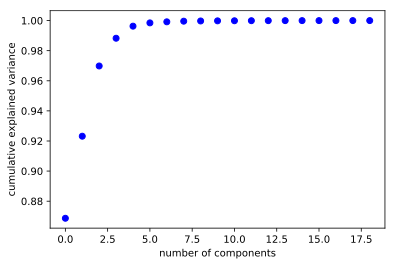

In [583]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'bo')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [584]:
pca = PCA(3)
pca_fit = pca.fit(X_train_imputed)
X_train_pca = pd.DataFrame(pca_fit.transform(X_train_imputed), columns=['pca1','pca2','pca3'], index=X_train.index)

In [568]:
X_train_pca = pd.concat([X_train_pca, X_train.iloc[:, 19:]], axis =1)

In [594]:
model3_score = get_CV_score(X_train_pca, y_train_log, False)
print ('Model 3 CV RMSE is:', model3_score)

Model 3 CV RMSE is: 0.216128953943


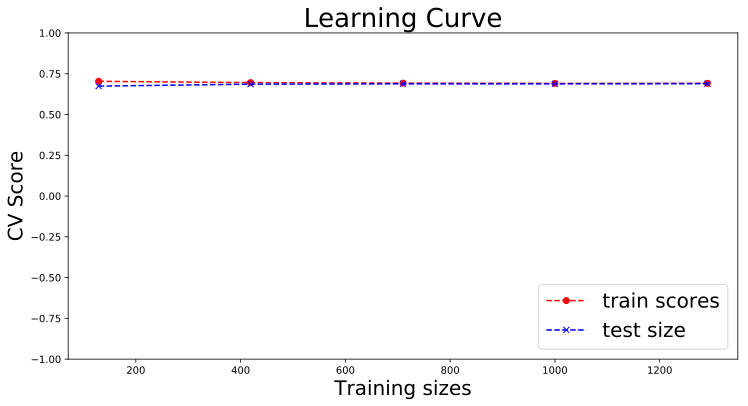

In [596]:
from sklearn.model_selection import learning_curve
# Make a model, say quadratic

lr = LinearRegression()
model3_fit = lr.fit(X_train_pca, y_train_log)
train_sizes, train_scores, test_scores = learning_curve(model3_fit, X_train_pca, y_train_log, cv=5)
ave_train_scores = train_scores.mean(axis=1)
ave_test_scores = test_scores.mean(axis=1)

learn_df  = pd.DataFrame({
    'train_size': train_sizes,
    'train_score': ave_train_scores,
    'test_score': ave_test_scores
})

plot_lm_0 = plt.figure(1)
plot_lm_0.set_figheight(6)
plot_lm_0.set_figwidth(12)
plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test size')
plt.legend(loc='lower right', fontsize=20)
plt.xlabel('Training sizes', fontsize=20)
plt.ylabel('CV Score', fontsize=20)
plt.title('Learning Curve', fontsize=26)
plt.ylim(-1,1)
plt.savefig('learning_curve-pca.png')

In [591]:
model3_sm = sm.OLS(y_train_log, (sm.add_constant(X_train_pca))).fit()
score = mean_squared_error(model3_sm.predict((sm.add_constant(X_train_pca)), y_train_log))
score = np.sqrt(np.mean(score)
print ('Model 3 training RMSE is:', score)
model3_sm.summary()

SyntaxError: invalid syntax (<ipython-input-591-22e66a68caf5>, line 4)

In [571]:
X_train_vif_pca, removed_cols_high_vif = remove_high_vif(X_train_pca, 5)

remaining variables are: 
                        colname       vif
0                         pca1  1.501306
1                         pca2  1.102888
2                         pca3  1.098412
3         store[T.Fremont, CA]  2.292557
4          store[T.Fresno, CA]  1.613880
5         store[T.Modesto, CA]  2.048986
6      store[T.Pleasanton, CA]  2.263368
7            store[T.Reno, NV]  2.106412
8       store[T.Roseville, CA]  2.326007
9      store[T.Sacramento, CA]  1.992480
10  store[T.San Francisco, CA]  2.254146
11       store[T.San Jose, CA]  2.066873
12     store[T.Santa Rosa, CA]  2.199014
13                make[T.Audi]  1.229948
14                 make[T.BMW]  1.874252
15               make[T.Buick]  1.131719
16            make[T.Cadillac]  1.130500
17           make[T.Chevrolet]  1.827610
18            make[T.Chrysler]  1.157277
19               make[T.Dodge]  1.682282
20                make[T.Fiat]  1.089023
21                make[T.Ford]  2.590379
22                 make[T.GMC]

In [572]:
removed_cols_high_vif

['Intercept']

In [573]:
get_CV_score(X_train_vif_pca, y_train_log, False)

0.17979438241284751

In [576]:
X_train_vif_pca.head()

,pca1,pca2,pca3,"store[T.Fremont, CA]","store[T.Fresno, CA]","store[T.Modesto, CA]","store[T.Pleasanton, CA]","store[T.Reno, NV]","store[T.Roseville, CA]","store[T.Sacramento, CA]",...,make[T.Mitsubishi],make[T.Nissan],make[T.Pontiac],make[T.Porsche],make[T.Scion],make[T.Smart],make[T.Subaru],make[T.Toyota],make[T.Volkswagen],make[T.Volvo]
stock_id,,,,,,,,,,,,,,,,,,,,,
16057160,-72.666224,-14.566691,9.662357,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16057266,-120.674461,-9.269476,12.615380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15867037,-42.598150,-38.453912,2.071433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16211748,261.841064,-16.772072,-43.775792,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16062084,-84.416336,-16.346767,-5.784700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [575]:
model3_sm = sm.OLS(y_train, sm.add_constant(X_train_vif_pca)).fit()
score = mean_squared_error(model3_sm.predict(sm.add_constant(X_train_vif_pca)), y_train_log)
#score = np.sqrt(np.mean(score))
print ('Model 3 training RMSE is:', score)
model3_sm.summary()

Model 3 training RMSE is: 468760330.373


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     114.7
Date:                Thu, 19 Jul 2018   Prob (F-statistic):               0.00
Time:                        11:21:08   Log-Likelihood:                -15772.
No. Observations:                1614   AIC:                         3.164e+04
Df Residuals:                    1567   BIC:                         3.189e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       2.025e+04    951.424     21.285      0.000    1.84e+04    2.21e+04
pca1                          51.2508      1.131     45.325      0.000      49.033      53.469
pca2                        -104.6268      3.868    -27.050      0.000    -112.214     -97.040
pca3                         -32.4136      4.184     -7.747      0.000     -40.621     -24.206
store[T.Fremont, CA]        1418.2758    529.968      2.676      0.008     378.754    2457.797
store[T.Fresno, CA]          848.2182    602.159      1.409      0.159    -332.905    2029.341
store[T.Modesto, CA]         942.8543    547.195      1.723      0.085    -130.457    2016.165
store[T.Pleasanton, CA]     1007.2351    527.153      1.911      0.056     -26.764    2041.234
store[T.Reno, NV]            728.3485    546.994      1.332      0.183    -344.568    1801.265
store[T.Roseville, CA]      1357.3156    519.876      2.611      0.009     337.590    2377.042
store[T.Sacramento, CA]     1031.7381    559.133      1.845      0.065     -64.990    2128.466
store[T.San Francisco, CA]    57.6589    536.425      0.107      0.914    -994.528    1109.846
store[T.San Jose, CA]        308.8170    553.429      0.558      0.577    -776.722    1394.356
store[T.Santa Rosa, CA]      332.8170    536.676      0.620      0.535    -719.861    1385.495
make[T.Audi]                2862.7026   1175.052      2.436      0.015     557.863    5167.542
make[T.BMW]                 -424.5708    954.581     -0.445      0.657   -2296.962    1447.821
make[T.Buick]              -1836.8828   1258.671     -1.459      0.145   -4305.740     631.974
make[T.Cadillac]            2866.0519   1526.216      1.878      0.061    -127.589    5859.693
make[T.Chevrolet]          -1510.1808    958.995     -1.575      0.116   -3391.229     370.867
make[T.Chrysler]           -5670.4641   1206.290     -4.701      0.000   -8036.576   -3304.352
make[T.Dodge]              -3377.7454    990.060     -3.412      0.001   -5319.727   -1435.764
make[T.Fiat]               -1517.3422   1385.890     -1.095      0.274   -4235.737    1201.052
make[T.Ford]               -2462.4262    909.740     -2.707      0.007   -4246.863    -677.990
make[T.GMC]                 1127.0466   1280.755      0.880      0.379   -1385.128    3639.221
make[T.Honda]               1108.7903    964.975      1.149      0.251    -783.988    3001.569
make[T.Hyundai]            -1583.4039    960.133     -1.649      0.099   -3466.685     299.877
make[T.Infiniti]            -253.3336   1095.418     -0.231      0.817   -2401.973    1895.306
make[T.Jaguar]              3898.0989   1520.357      2.564      0.010     915.951    6880.246
make[T.Jeep]                -712.0696   1008.686     -0.706      0.480   -2690.587    1266.448
make[T.Kia]                -1578.4311   107